# Model Dependency Analysis Using SHAP: Forwards_Model

The task here is to analyze partial dependency of the trained F_Model using SHAP(SHapley Additive exPlanations).

In [1]:
import joblib
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

shap.initjs()

/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Data

In [2]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 41 or more games played
forwards_41GP = forwards[(forwards['GP'] >= 41)].copy()
test_train_data = forwards_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Load in the pipeline and the models features using joblib

pipeline = joblib.load('Forward_Model/forward_salary_pipeline.pkl')

/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarni

In [4]:
# Make predictions (this part seems fine)
y_pred = pipeline.predict(X_test)

# get rfecv from pipeline
rfecv = pipeline.named_steps['selector']

# Now, for SHAP values, we need to ensure we only consider features that were kept after RFECV
# Extract the support mask from RFECV to identify selected features
selected_features = rfecv.get_support(indices=True)
selected_feature_names = [numerical_features[i] for i in selected_features]

# Apply transformation only on selected features
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)[:, selected_features]
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=selected_feature_names, index=X_test.index)

# Proceed with SHAP explainer
explainer = shap.Explainer(pipeline.named_steps['regressor'].get_booster())
shap_values = explainer(X_test_transformed_df)  

ValueError: columns are missing: {'IXG/60', 'HITS/60', 'LDCF/60', 'HDGA/60', 'PENALTIES DRAWN/60', 'REBOUNDS CREATED/60', 'CF/60', 'XGA/60', 'MDCF/60', 'SA/60', 'MINOR/GP', 'GOALS/60', 'FF/60', 'PIM/GP', 'SF/60', 'TOTAL PENALTIES/GP', 'HDCA/60', 'HITS TAKEN/60', 'NEU.\xa0ZONE FACEOFFS/GP', 'GA/60', 'FIRST ASSISTS/60', 'MAJOR/60', 'TOTAL POINTS/60', 'HDCF/60', 'TOTAL ASSISTS/60', 'GIVEAWAYS/60', 'TAKEAWAYS/60', 'GF/60', 'OFF.\xa0ZONE FACEOFFS/GP', 'DEF.\xa0ZONE FACEOFFS/GP', 'SHOTS/60', 'LDGF/60', 'DEF.\xa0ZONE STARTS/GP', 'NEU.\xa0ZONE FACEOFFS/60', 'TOI/GP', 'MINOR/60', 'OFF.\xa0ZONE STARTS/60', 'FA/60', 'ISCF/60', 'PIM/60', 'ON\xa0THE\xa0FLY STARTS/60', 'SCA/60', 'LDGA/60', 'MISCONDUCT/60', 'ICF/60', 'MISCONDUCT/GP', 'SECOND ASSISTS/60', 'OFF.\xa0ZONE FACEOFFS/60', 'RUSH ATTEMPTS/60', 'MDCA/60', 'HDGF/60', 'TOTAL PENALTIES/60', 'XGF/60', 'NEU.\xa0ZONE STARTS/60', 'MDGF/60', 'IHDCF/60', 'IFF/60', 'ON\xa0THE\xa0FLY STARTS/GP', 'MAJOR/GP', 'FACEOFFS LOST/60', 'MDGA/60', 'FACEOFFS WON/60', 'CA/60', 'NEU.\xa0ZONE STARTS/GP', 'SHOTS BLOCKED/60', 'SCF/60', 'DEF.\xa0ZONE STARTS/60', 'DEF.\xa0ZONE FACEOFFS/60', 'OFF.\xa0ZONE STARTS/GP', 'LDCA/60'}

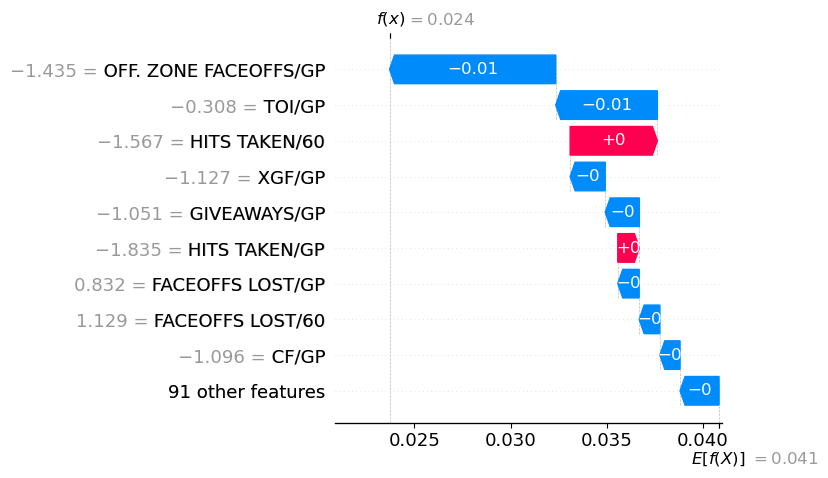

In [ ]:
fig = plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.gcf().set_size_inches(5,5)
plt.show()

In [42]:
# Access the trained XGBRegressor model from the pipeline
xgb_model = pipeline.named_steps['regressor']

# Retrieve the feature importances
feature_importances = xgb_model.feature_importances_

# Assuming 'numerical_features' holds the original names of the features prior to fitting
# and we are also taking into account that some features might have been dropped by the RFECV step
selected_features = numerical_features[rfecv.support_]

# Combine feature names and their importance scores in a dictionary
feature_importance_dict = dict(zip(selected_features, feature_importances))

# Sort the dictionary by importance scores in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Print sorted feature importances
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: OFF. ZONE FACEOFFS/GP, Importance: 0.1977846622467041
Feature: XGF/GP, Importance: 0.11365099251270294
Feature: CF/GP, Importance: 0.08354666829109192
Feature: TOI/GP, Importance: 0.0528184212744236
Feature: HDCF/GP, Importance: 0.017834370955824852
Feature: LDCF/GP, Importance: 0.014079902321100235
Feature: FF/GP, Importance: 0.013028725981712341
Feature: HITS TAKEN/60, Importance: 0.011447837576270103
Feature: DEF. ZONE FACEOFFS/GP, Importance: 0.009769447147846222
Feature: SHOTS BLOCKED/60, Importance: 0.009443698450922966
Feature: TOTAL POINTS/GP, Importance: 0.00942047405987978
Feature: GIVEAWAYS/GP, Importance: 0.008823645301163197
Feature: SHOTS/GP, Importance: 0.008506507612764835
Feature: TOTAL PENALTIES/60, Importance: 0.00809792522341013
Feature: DEF. ZONE FACEOFFS/60, Importance: 0.007881722413003445
Feature: FACEOFFS WON/GP, Importance: 0.007778473198413849
Feature: NEU. ZONE FACEOFFS/GP, Importance: 0.0072187576442956924
Feature: FACEOFFS WON/60, Importance: 0.00

In [41]:
shap.plots.force(shap_values[:100])

<Figure size 640x480 with 0 Axes>

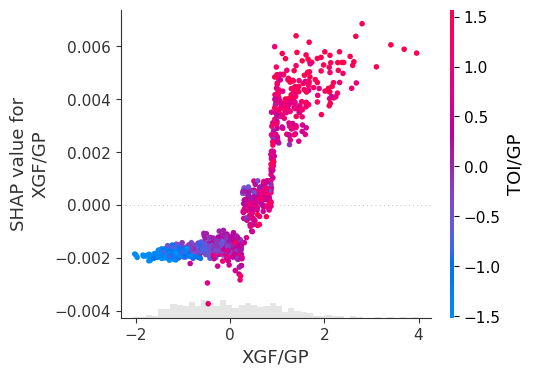

In [29]:
fig = plt.figure()
shap.plots.scatter(shap_values[:, "XGF/GP"], color=shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

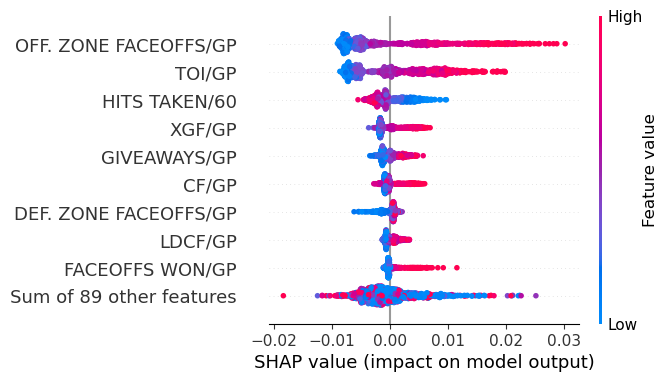

In [9]:
fig = plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()

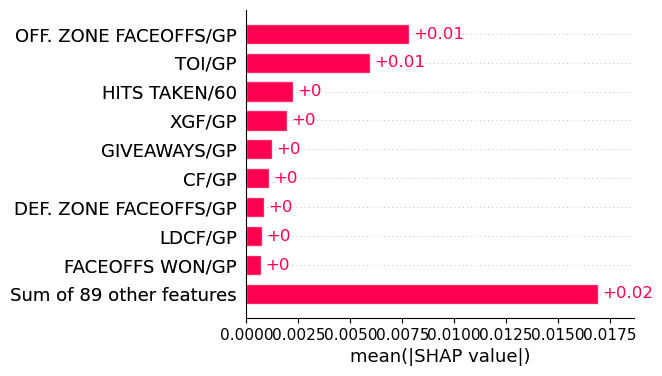

In [10]:
fig = plt.figure()
shap.plots.bar(shap_values, show=False)
plt.gcf().set_size_inches(5,4)
plt.show()
